# 決定木

クラス分類と回帰タスクに広く用いられている．

決定木における学習は，正解に最も早くたどり着けるような一連のYES/NO型の質問の学習を意味する．機械学習では，これらの質問はテストと呼ばれる．


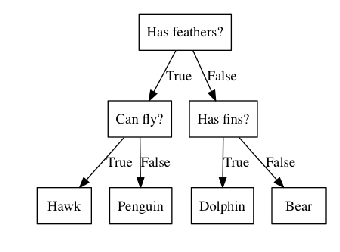

In [8]:
import mglearn
import matplotlib.pyplot as plt

mglearn.plots.plot_animal_tree()
plt.show()

### 構築

データの再帰分割は，対象の領域に一つの対象値しか含まれなくなるまで繰り返される．一つの対象値のデータポイントしか含まれないような決定木の葉を純粋と呼ぶ．

### 複雑さの制御

葉が純粋になるまで，分割を続けると訓練データに対して過剰適合してしまう．

- 過剰適合を防ぐためには
    - 事前枝刈り
        - 構築過程で木の生成を早めに止める
    - 事後枝刈り
        - 木の深さを制限
        - 葉の最大値を制限する
        - 分割する際に，その中に含まれている点の最小数を決めておく
        
- scikit\-learn
    - DecisionTreeRegressor, DecisionTreeClassifier

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set:{:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set:{:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set:1.000
Accuracy on test set:0.937


In [14]:
# 事前枝刈り

tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set:{:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set:{:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set:0.988
Accuracy on test set:0.951


In [15]:
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file="tree.dot", class_names=["maligant", "benign"], feature_names=cancer.feature_names, impurity=False, filled=True)

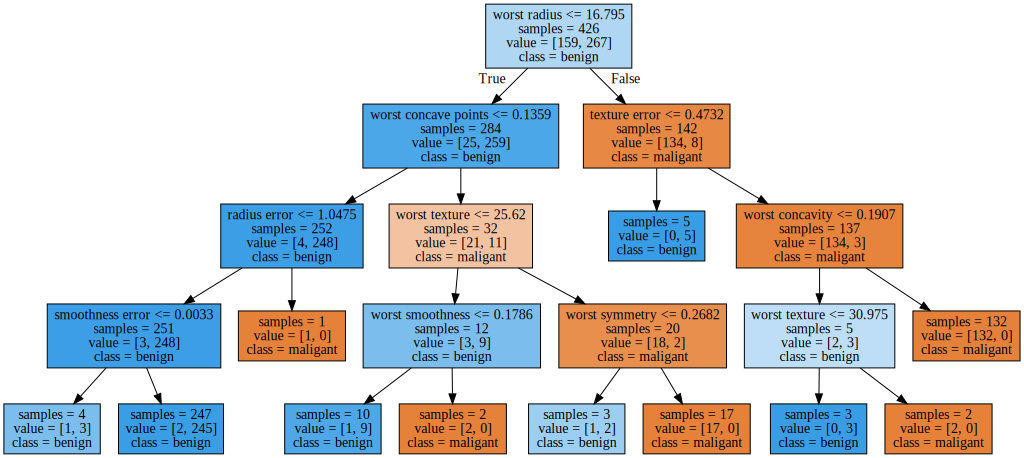

In [16]:
import graphviz

with open("tree.dot") as f:
    dot_ghraph = f.read()
graphviz.Source(dot_ghraph)

### 決定木の特徴量の重要性

要約に最もよく使われるのは、特徴量の重要度。決定木が行う判断にとって、個々の特徴量がどの程度重要かを示す割合である。

0と1の間の数で、0は「全く使われていない」、1は「完全にターゲットを予想出来る」を意味する。特徴量の重要度の和は常に1になる

In [17]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.01019737  0.04839825  0.          0.
  0.0024156   0.          0.          0.          0.          0.
  0.72682851  0.0458159   0.          0.          0.0141577   0.          0.018188
  0.1221132   0.01188548  0.        ]


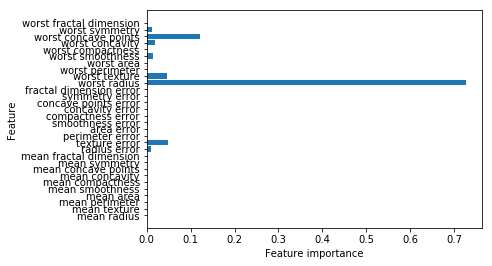

In [23]:
import numpy as np

def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align="center")
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
plot_feature_importances_cancer(tree)
plt.show()

Feature importances: [ 0.  1.]


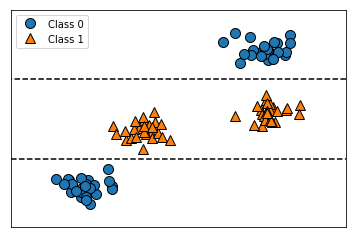

In [48]:
tree = mglearn.plots.plot_tree_not_monotone()
plt.show()

### 決定木による回帰の注意点

決定木によるモデルを回帰に使う際には外挿が出来ない、つまり訓練データのレンジの外側に対しては予測が出来ない

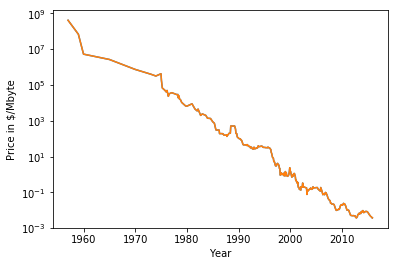

In [52]:
import os
import pandas as pd
ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "ram_price.csv"))

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")
plt.show()

In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import numpy as np

# 過去のデータを用いて2000年以降の価格を予想する
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# 日付に基いて価格を予測
X_train = data_train.date[:, np.newaxis]
# データをターゲットの関係を単純にするために対数変換
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

# 全ての価格を予想
X_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

# 対数変換をキャンセルするために逆変換
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

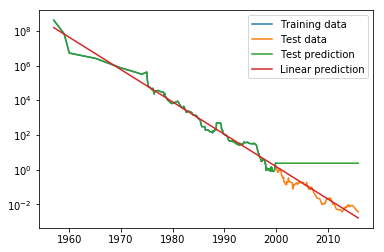

In [57]:
plt.semilogy(data_train.date, data_train.price, label="Training data")
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, price_tree, label="Test prediction")
plt.semilogy(ram_prices.date, price_lr, label="Linear prediction")
plt.legend()
plt.show()

決定木は訓練データに無い領域に関しては、「新しい」答えを生成することが出来ない.


### 決定木の利点, 欠点, パラメータ

- パラメータ

```
事前枝刈りパラメータ
過剰適合を防ぐには戦略を指定する: max_depth, max_leaf_nodes, min_samples_leaf
```

- 利点

    - 結果のモデルが容易に可視化可能
    - データのスケールに対して完全に不変である
         - 個々の特徴量は独立に処理され、データの分割はスケールに依存しないので、決定木においては特徴量の正規化や標準化が必要ない
         - 二値特徴量と連続値特徴量が混ざっていても問題ない
    
- 欠点

    - 事前枝刈りを行っても、過剰適合しやすく汎化性能が低い傾向にある
        => 解決策として、アンサンブル法が用いられる

-------

## 決定木のアンサンブル法

`アンサンブル法`とは複数の機械学習モデルを組み合わせることで、より強力なモデルを構築する手法。様々なデータセットに対するクラス分類や回帰に関して有効だとわかっているアンサンブル法は以下の二つである
    
    - ランダムフォレスト
    - 勾配ブースティング決定木

### ランダムフォレスト

少しづつ異なる決定木を沢山集めたもの。ランダムフォレストは、個々の決定木は比較的うまく予測出来ているが、一部のデータに対して過剰適合してしまっているという考えに基づいている。それぞれ異なった方向に過剰適合した決定木を沢山作れば、その結果の平均を取ることで過剰適合の度合いを減らすことが出来る。

ランダムフォレストは個々の決定木を互いに異なるように、決定木の構築過程で乱数を導入していることからついている。導入先は以下の二つである。

    - 決定木を作る為のデータポイントの選択方法
    - 分枝テストに用いる特徴を選択する方法

### ランダムフォレストの構築

ランダムフォレストを構築するには、構築する決定木の数を決めなければならない。

```
    - RandomForestRegressor
    - RandomForestClassifier
```
のn_estimatorsのパラメータ。

1. 決定木を作るには、まずデータから`ブートストラップサンプリング`を行う。ブートストラップサンプリングとはn_samples個のデータポイントから、交換でありでデータポイントをランダムにn_samples回選び出す手法である(復元抽出)

2. この新しいデータセットを用いて決定木を作る。個々のノードで最適なテストを選ぶのではなく、特徴量のサブセットをランダムに選び、その特徴量を使うものの中から最適なテストを選ぶ。

3. 全ての決定木について予測を行い、回帰の場合にはこれらの結果の平均値を最終的な予測として用いる。クラス分類の場合には「ソフト投票」戦略が用いられる

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=2,
            verbose=0, warm_start=False)

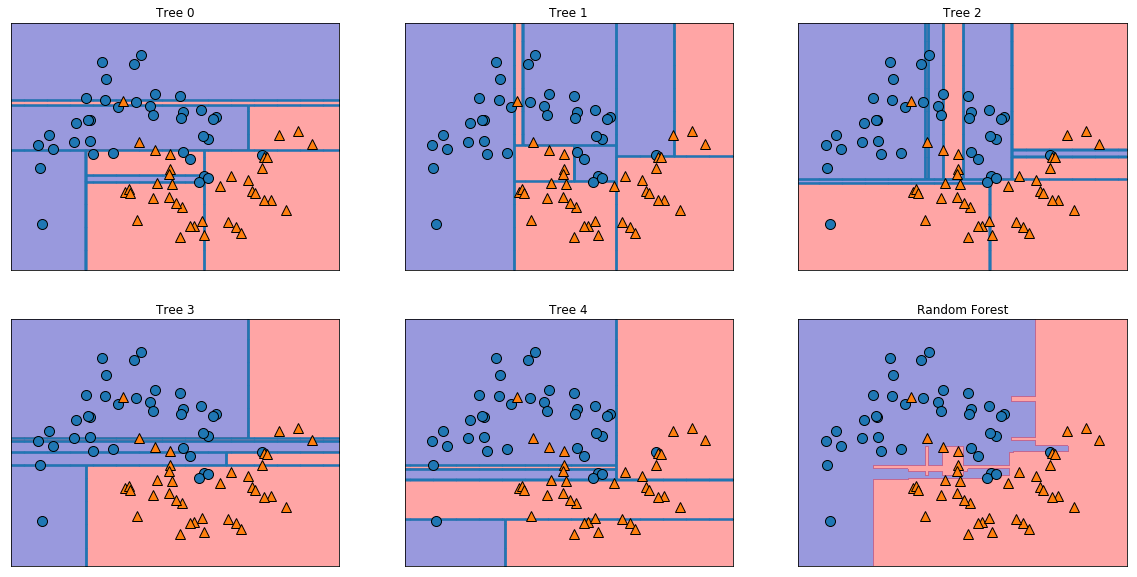

In [67]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.show()

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("Accuracy on training set:{:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set:{:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set:0.998
Accuracy on test set:0.944


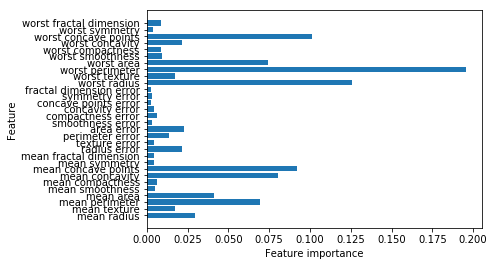

In [76]:
plot_feature_importances_cancer(forest)
plt.show()

### ランダムフォレストの利点, 欠点, パラメータ

- パラメータ

```
n_estimators: より多くの決定木の平均を取るため、大きければ大きいほどよい
max_features: 個々の決定木の乱数性を決定すると共に、小さくなると過剰適合が低減する。一般的にはデフォルト値でよい
max_depth: 事前枝刈り
```

- 利点

    - 強い
    
- 欠点

    - 予測のプロセスが分かりにくい

### 勾配ブースティング回帰木

一つ前に決定木の誤りを次の決定木が修正するようにして、決定木を順番に作っていく。勾配ブースティングのポイントは浅い決定木のような、簡単なモデルを多数組み合わせることにある。ランダムフォレストに比べ、パラメータ設定の影響を受けやすいが正しく設定されていれば、こちらの方が性能がいい。

勾配ブースティング回帰木には、事前枝刈りとアンサンブルに用いる決定木の数を設定するパラメータの他に学習率というパラメータがある。学習率を大きくすると個々の決定木が強く補正を行おうとし、モデルは複雑になる。

In [78]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set:{:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set:{:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set:1.000
Accuracy on test set:0.958


In [79]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Accuracy on training set:{:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set:{:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set:0.991
Accuracy on test set:0.972


In [80]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("Accuracy on training set:{:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set:{:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set:0.988
Accuracy on test set:0.965


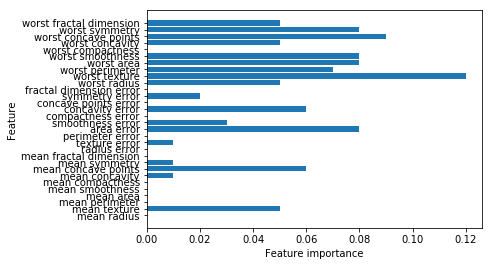

In [84]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)
plt.show()

### 勾配ブースティング回帰木の長所, 欠点, パラメータ

- パラメータ

```
n_estimators: 決定木の数を指定
learning_rate: 誤りの補正度合いを制御する -> 小さいと、複雑なモデルを作るにはより沢山の決定木が必要になる
```

- 利点

    - 強い(教師あり学習の中でもトップクラス)
    
- 欠点

    - パラメータのチューニングが大切であること
    - 時間がかかる